In [27]:
words = open('names.txt').read().splitlines()

In [402]:
import random

In [405]:
random.shuffle(words)

In [406]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Construct our dataset i.e three characters as input and one character as output

for example:

dup --> e


In [165]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [407]:
# build the dataset

block_size = (
    3  # context length: how many characters do we take to predict the next one?
)
X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)


In [37]:
len(stoi)

27

### Initial Character embeddings

In [49]:
block_size

3

In [40]:

emb_dm = 2
emb = torch.randn((len(stoi), emb_dm))

In [45]:
X[0]

tensor([0, 0, 0])

In [52]:
emb[X[0]]

tensor([[ 0.2507, -0.2480],
        [ 0.2507, -0.2480],
        [ 0.2507, -0.2480]])

In [56]:
X[:2].shape

torch.Size([2, 3])

In [57]:
emb[X[:2]]

tensor([[[ 0.2507, -0.2480],
         [ 0.2507, -0.2480],
         [ 0.2507, -0.2480]],

        [[ 0.2507, -0.2480],
         [ 0.2507, -0.2480],
         [-0.6253, -0.8834]]])

In [58]:
emb[X[:2]].view(-1, block_size*emb_dm)

tensor([[ 0.2507, -0.2480,  0.2507, -0.2480,  0.2507, -0.2480],
        [ 0.2507, -0.2480,  0.2507, -0.2480, -0.6253, -0.8834]])

In [48]:
X.shape

torch.Size([228146, 3])

tensor([[ 0.2507, -0.2480,  0.2507, -0.2480,  0.2507, -0.2480],
        [ 0.2507, -0.2480,  0.2507, -0.2480, -0.6253, -0.8834],
        [ 0.2507, -0.2480, -0.6253, -0.8834,  0.2861,  1.1079],
        ...,
        [-1.0058,  0.0051, -1.0058,  0.0051,  0.3354, -1.0420],
        [-1.0058,  0.0051,  0.3354, -1.0420, -1.0058,  0.0051],
        [ 0.3354, -1.0420, -1.0058,  0.0051, -0.6214, -1.2187]])

## Convert names into feature vector of dimension 3

In [96]:
X_emb = emb[X].view(-1, block_size*emb_dm)

In [97]:
X_emb.shape

torch.Size([228146, 6])

## make our simple NN

#### Define NN structure

In [121]:
w_dim = 100

W1 = torch.randn(block_size*emb_dm, w_dim, requires_grad=True)
b1 = torch.randn(w_dim, requires_grad = True)

W2 = torch.randn(w_dim, len(stoi), requires_grad=True)
b2 = torch.randn(len(stoi), requires_grad = True)

parameters = [W1, b1, W2, b2]

### Construct a training loop


In [122]:
Y[0]

tensor(5)

### Check if our current implementation matches with the pytorch's definition of cross_entropy

In [123]:
for i in range(1):
    
    X_emb = emb[X].view(-1, block_size*emb_dm)
    
    inputs = X_emb @ W1 + b1
    inputs = torch.tanh(inputs)
    logits = inputs @ W2 + b2
    
    logits = logits.exp()
    logits = logits / logits.sum(1, keepdim = True)
    print(logits.shape)
    prob = logits[torch.arange(len(X)), Y]
    
    loss = -1*torch.log(prob).mean()
    print(loss)
    

torch.Size([228146, 27])
tensor(15.7847, grad_fn=<MulBackward0>)


In [124]:
for i in range(1):
    X_emb = emb[X].view(-1, block_size*emb_dm)
    inputs = X_emb @ W1 + b1
    inputs = torch.tanh(inputs)
    logits = inputs @ W2
    
#     logits = logits.exp()
#     logits = logits / logits.sum(1, keepdim = True)
#     print(logits.shape)
#     prob = logits[torch.arange(len(X)), Y]
    
#     loss = -1*torch.log(prob).mean()
    loss = F.cross_entropy(logits,Y)
    print(loss)
    

tensor(14.9954, grad_fn=<NllLossBackward0>)


### Train our NN

This is just training on 32 data, 

In this case, we are overfitting our data, i.e we have enormous weights vs very less data (i.e 32)

so, our weights are memorizing these examples very easily

In [130]:
for i in range(1000):
    
    X_emb = emb[X[:32]].view(-1, block_size*emb_dm)
    inputs = X_emb @ W1 + b1
    inputs = torch.tanh(inputs)
    logits = inputs @ W2 + b2
    
    loss = F.cross_entropy(logits,Y[:32])

    
    ## Zero out the gradient
    for p in parameters:
        p.grad = None
        
    loss.backward()
    lr = 0.1
    
    for p in parameters:
        p.data += -lr*p.grad 

print(loss)

tensor(0.2572, grad_fn=<NllLossBackward0>)


### Mini-batches

in practice we don't calculate our loss on whole data set, but only on mini-batches and run it more iterations. 

by doing this we are frequently updating our parameters.

Reason for doing this ?

1. Scales better with large dataset, we can parallely train.

2. Calculating loss on the whole training data smoothens gradients, potentially leading to overfitting if the model gets stuck in sharp local minima.

3. Mini-batch training introduces some noise into the gradient updates because they are computed on a subset of the data. This noise can help the model escape local minima or saddle points and explore the parameter space better, potentially leading to improved generalization

In [148]:
for i in range(1000):
    
    # picking mini batches of size 32 from the whole dataset
    
    mb = torch.randint(0, X.shape[0], (32,))
    X_emb = emb[X[mb]].view(-1, block_size*emb_dm)
    inputs = X_emb @ W1 + b1
    inputs = torch.tanh(inputs)
    logits = inputs @ W2 + b2
    
    loss = F.cross_entropy(logits,Y[mb])

    
    ## Zero out the gradient
    for p in parameters:
        p.grad = None
        
    loss.backward()
    lr = 0.1
    
    for p in parameters:
        p.data += -lr*p.grad 

print(loss)

tensor(2.4929, grad_fn=<NllLossBackward0>)


### Let's choose decent learning rate

In [203]:
w_dim = 100

W1 = torch.randn(block_size*emb_dm, w_dim, requires_grad=True)
b1 = torch.randn(w_dim, requires_grad = True)

W2 = torch.randn(w_dim, len(stoi), requires_grad=True)
b2 = torch.randn(len(stoi), requires_grad = True)

parameters = [W1, b1, W2, b2]

In [204]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lre_list = []
loss_list = []

In [205]:
for i in range(1000):
    
    # picking mini batches of size 32 from the whole dataset
    
    mb = torch.randint(0, X.shape[0], (32,))
    X_emb = emb[X[mb]].view(-1, block_size*emb_dm)
    
    inputs = X_emb @ W1 + b1
    inputs = torch.tanh(inputs)
    logits = inputs @ W2 + b2
    
    loss = F.cross_entropy(logits,Y[mb])

    
    ## Zero out the gradient
    for p in parameters:
        p.grad = None
        
    loss.backward()
    lr = 0.1
    
    for p in parameters:
        p.data += -lrs[i]*p.grad 

    lre_list.append(lre[i])
    loss_list.append(loss.item())
    
    
print(loss)

tensor(4.8102, grad_fn=<NllLossBackward0>)


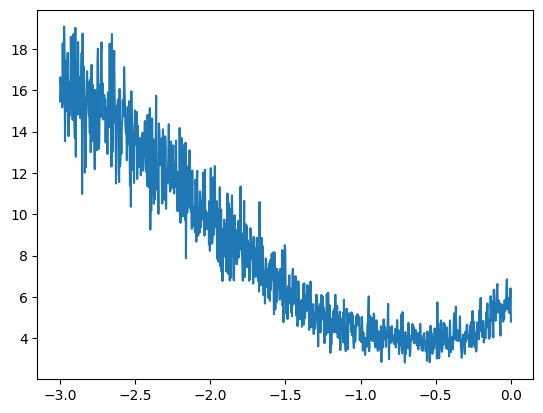

In [206]:
plt.plot(lre_list, loss_list)

loss on whole data

In [207]:
X_emb = emb[X].view(-1, block_size*emb_dm)

inputs = X_emb @ W1 + b1
inputs = torch.tanh(inputs)
logits = inputs @ W2 + b2

loss = F.cross_entropy(logits,Y)
loss

tensor(6.1626, grad_fn=<NllLossBackward0>)

### Lets try to optimize loss


In [223]:
w_dim = 100

W1 = torch.randn(block_size*emb_dm, w_dim, requires_grad=True)
b1 = torch.randn(w_dim, requires_grad = True)

W2 = torch.randn(w_dim, len(stoi), requires_grad=True)
b2 = torch.randn(len(stoi), requires_grad = True)

parameters = [W1, b1, W2, b2]

In [282]:


for i in range(10000):
    
    # picking mini batches of size 32 from the whole dataset
    
    mb = torch.randint(0, X.shape[0], (32,))
    X_emb = emb[X[mb]].view(-1, block_size*emb_dm)
    
    inputs = X_emb @ W1 + b1
    inputs = torch.tanh(inputs)
    logits = inputs @ W2 + b2
    
    loss = F.cross_entropy(logits,Y[mb])

    
    ## Zero out the gradient
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # This is a good learning rate, determined from the plot above
    lr = 0.001
    
    for p in parameters:
        p.data += -lr*p.grad 


    
print(loss)

tensor(2.3864, grad_fn=<NllLossBackward0>)


In [283]:
mb = torch.randint(0, X.shape[0], (32,))
X_emb = emb[X].view(-1, block_size*emb_dm)

inputs = X_emb @ W1 + b1
inputs = torch.tanh(inputs)
logits = inputs @ W2 + b2

loss = F.cross_entropy(logits,Y)

In [284]:
loss

tensor(2.2467, grad_fn=<NllLossBackward0>)

### Concept of overfitting

when we have small data but large parameters, the parameters will memorize our training data resulting in lower loss on the training set, but it would not yield better results, because all its doing is memorizing, and when it sees new data, loss would be very high.

The way to see if it is overfitting or not is by diving the data into train, dev, and test dataset

In [287]:
Xtrn,Ytrn = X[:int(0.8*X.shape[0])], Y[:int(0.8*Y.shape[0])]

In [289]:
Xdev, Ydev = X[int(0.8*X.shape[0]): int(0.9*X.shape[0])], Y[int(0.8*Y.shape[0]) : int(0.9*Y.shape[0])]

In [291]:
Xtest,Ytest = X[int(0.9*X.shape[0]):], Y[int(0.9*Y.shape[0]):]

In [295]:
Xtrn.shape

torch.Size([182516, 3])

In [444]:
w_dim = 100
emb_dm = 10

emb = torch.randn((len(stoi), emb_dm),  requires_grad = True)

W1 = torch.randn(block_size*emb_dm, w_dim, requires_grad=True)
b1 = torch.randn(w_dim, requires_grad = True)

W2 = torch.randn(w_dim, len(stoi), requires_grad=True)
b2 = torch.randn(len(stoi), requires_grad = True)

parameters = [emb, W1, b1, W2, b2]

In [445]:
lossi = []
stepi = []

In [446]:


for i in range(200000):
    
    # picking mini batches of size 32 from the whole dataset
    
    mb = torch.randint(0, Xtrn.shape[0], (32,))
    X_emb = emb[X[mb]].view(-1, block_size*emb_dm)
    
    inputs = X_emb @ W1 + b1
    inputs = torch.tanh(inputs)
    logits = inputs @ W2 + b2
    
    loss = F.cross_entropy(logits,Ytrn[mb])

    
    ## Zero out the gradient
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # This is a good learning rate, determined from the plot above
    lr = 0.1 if i < 100000 else 0.01
    
    for p in parameters:
        p.data += -lr*p.grad 

    stepi.append(i)
    lossi.append(loss.item())
    


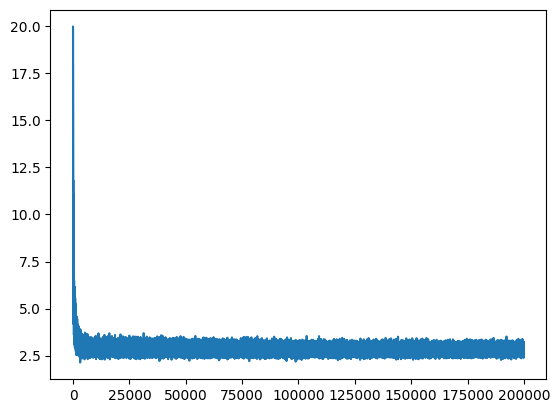

In [447]:
plt.plot(stepi, lossi)

In [448]:

X_emb = emb[Xtrn].view(-1, block_size*emb_dm)

inputs = X_emb @ W1 + b1
inputs = torch.tanh(inputs)
logits = inputs @ W2 + b2

loss = F.cross_entropy(logits,Ytrn)
loss

tensor(2.7993, grad_fn=<NllLossBackward0>)

In [449]:

X_emb = emb[Xdev].view(-1, block_size*emb_dm)

inputs = X_emb @ W1 + b1
inputs = torch.tanh(inputs)
logits = inputs @ W2 + b2

loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.9169, grad_fn=<NllLossBackward0>)

### Sample 

In [453]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 100)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb_new = emb[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb_new.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))


felylnryeenojai.
nnlkenh.
onreaalclfnmpypdiie.
al.
zvzlanzd.
hytodpelm.
kzkelshaukg.
mtiil.
he.
bieiluerhryn.
y.
via.
h.
k.
ve.
obokrlryalazl.
ayynmglo.
h.
ert.
.
